# Visualisation of LFP & Sleep scoring

### Load LFP and packages

In [1]:
cd "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/"

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023


In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby


from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

%matplotlib widget

In [20]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Open Ephys folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)
Stored 'dpath' (str)


In [45]:
folder_base = Path(dpath) 

filename2 = folder_base / f'RawDataChannelExtractedDS.npy'

ScoringFile = folder_base / f'ScoredSleep.npy'
ScoringFile2 = folder_base / f'ScoredSleep_AB.npy'
SleepScoredTS=np.load(ScoringFile)
SleepScoredTS2=np.load(ScoringFile2)

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 

freqLFP=1000
All = np.load(filename2, mmap_mode= 'r')

def readfile(file):
  with open(file, encoding="utf-8") as file:
    list = []
    for row in file:
      temp = row.split()
      list.append(temp[:])
    return list

mice = os.path.basename(os.path.dirname(os.path.dirname(folder_base)))
allchannels = pd.read_excel(Channels)

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
EMGch1=int(allchannels[mice][3])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 
S1  =  All[:, S1ch1]-All[:, S1ch2] 
EMG  =  All[:, EMGch1]

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS) - 1, len(SleepScoredTS))
new_indices = np.linspace(0, len(SleepScoredTS) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS, kind='previous')
SleepScoredTS_upscaled = interpolated_func(new_indices)
SleepScoredTS_upscaled = np.round(SleepScoredTS_upscaled * 2) / 2


# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS2) - 1, len(SleepScoredTS2))
new_indices = np.linspace(0, len(SleepScoredTS2) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS2, kind='previous')
SleepScoredTS_upscaled2 = interpolated_func(new_indices)
SleepScoredTS_upscaled2 = np.round(SleepScoredTS_upscaled2 * 2) / 2



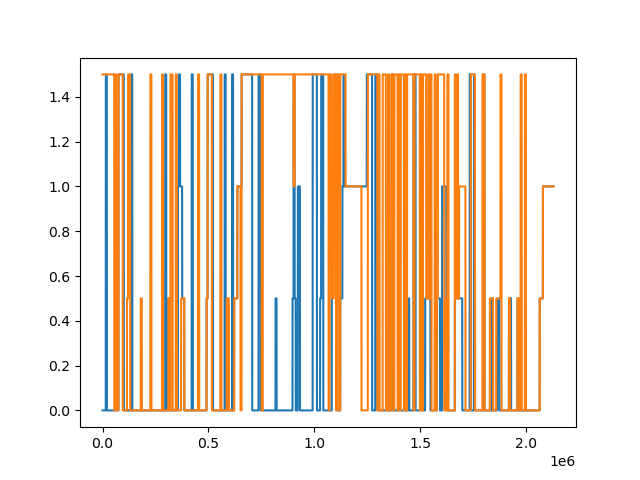

In [46]:
plt.close()
plt.plot(SleepScoredTS_upscaled)
plt.plot(SleepScoredTS_upscaled2)
plt.show()


In [47]:
OldSWSdetection=folder_base / f'SWRproperties_AB.csv'
SWR_prop = pd.read_csv(OldSWSdetection, index_col=0)            
SWR_prop=SWR_prop.values
SWR_peak = np.transpose(SWR_prop[:,0].astype(int))
SWR_start = np.transpose(SWR_prop[:,3].astype(int))
SWR_end = np.transpose(SWR_prop[:,4].astype(int))

OldS1spdldetection=folder_base / f'Spindlesproperties_S1_AB.csv'
S1spdl_prop = pd.read_csv(OldS1spdldetection, index_col=0)            
S1spdl_prop=S1spdl_prop.values
S1spdl_peak = np.transpose(S1spdl_prop[:,0].astype(int))
S1spdl_start = np.transpose(S1spdl_prop[:,3].astype(int))
S1spdl_end = np.transpose(S1spdl_prop[:,4].astype(int))

OldPFCspdldetection=folder_base / f'Spindlesproperties_PFC_AB.csv'
PFCspdl_prop = pd.read_csv(OldPFCspdldetection, index_col=0)            
PFCspdl_prop=PFCspdl_prop.values
PFCspdl_peak = np.transpose(PFCspdl_prop[:,0].astype(int))
PFCspdl_start = np.transpose(PFCspdl_prop[:,3].astype(int))
PFCspdl_end = np.transpose(PFCspdl_prop[:,4].astype(int))

# EphyViewer
### LFPs, FFT, Sleep scoring


In [48]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource

app = mkQApp()

sample_rate = freqLFP
t_start = 0.

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
#and asign them to some channels each
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}

#mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
combined = np.stack([(S1), (PFC), (CA1)/5, (EMG)/5], axis = 1)
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True

view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

#create a time freq viewer conencted to the same source
view3 = TimeFreqViewer(source=source, name='FFT')

view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 30
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz

view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch1', 'clim'] = 300
view3.by_channel_params['ch2', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True
view3.by_channel_params['ch1', 'visible'] = True
view3.by_channel_params['ch2', 'visible'] = True
view3.by_channel_params['ch3', 'visible'] = False


array=SleepScoredTS_upscaled2
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view2= EpochViewer(source=source_ep, name='Scoring')

view2.by_channel_params['ch0', 'color'] = '#5555FF'
view2.by_channel_params['ch1', 'color'] = '#AA00FF'
view2.by_channel_params['ch2', 'color'] = '#00AA00'
view2.by_channel_params['ch3', 'color'] = '#FFFFFF'



#add them to mainwindow
win.add_view(view1)
win.add_view(view2)
win.add_view(view3)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0010476112365722656 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.004122018814086914 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.014503717422485352 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration 

0